Tutorial: Own field generators
=================
*01/2021: updated to pyGDM v1.1+*

In this quick tutorial we demonstrate how to implement a user-defined fundamental field. We will do this at the example of two focused beams with different focal spot and relative phase.
All other parameters will be equal for both beams (spotsize, amplitude, phase ...)

We first load some modules
-------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import fields
from pyGDM2 import tools
from pyGDM2 import visu

Implement the field generator
--------------------------------------

We implement the own field generator function calle "*double_gaussian*". Internally, it will call *gaussian* twice with different focal positions and an optional relative phase.

For some processing routines like `linear.nearfield`, the field generators need to accept a kwarg *returnField*, which is either "E" or "B" and tells the function wether the electric or magnetic field of the incident field is to be returned. In our case, we simply pass this argument through to the `gaussian` generator without actively using it.

In [2]:
## ---------- Setup incident field generator, coherent sum of two gaussians
def double_gaussian(pos, env_dict, wavelength, 
                   theta_polar1, theta_polar2,
                   xSpot1, ySpot1, zSpot1, 
                   xSpot2, ySpot2, zSpot2, 
                   relative_phase=0,
                   spotsize=-1, returnField='E'):
    """Two focused beams, based on `fields.gaussian`
    
    theta_xxx are linear polarization angles in degrees, 0deg --> X
    relative phase in degrees, 
    """
    from pyGDM2 import fields
    
    ## --- evaluate focused beam twice using the two focal positions
    ## note: we have to pass the 'returnField' argument so automatic electric/magnetic 
    ## field calculations will work correctly
    Efield1 = fields.gaussian(pos, env_dict, wavelength, 
                              theta=theta_polar1, 
                              xSpot=xSpot1, ySpot=ySpot1, zSpot=zSpot1, 
                              spotsize=spotsize, 
                              returnField=returnField)
    Efield2 = fields.gaussian(pos, env_dict, wavelength, 
                              theta=theta_polar2, 
                              xSpot=xSpot2, ySpot=ySpot2, zSpot=zSpot2, 
                              spotsize=spotsize, 
                              phase=relative_phase,     # additional phase on second beam
                              returnField=returnField)
    
    ## --- get the complex x/y/z field components as individual arrays for summation
    Ex1, Ey1, Ez1 = Efield1.T
    Ex2, Ey2, Ez2 = Efield2.T
    
    ## --- add both beams
    Ex = Ex1 + Ex2
    Ey = Ey1 + Ey2
    Ez = Ez1 + Ez2
    
    ## --- return as fortran array to avoid copying of arrays in memory 
    return np.asfortranarray(np.transpose([Ex, Ey, Ez]))

Evaluate the new field generator in a test frame
---------------------------------------------

Now we setup a test-frame in which we evaluate the new double-spot field as well as a single focused plane wave for comparison. We will plot the X-polarized field in the *XZ* plane.

In [3]:
## --- single focused beam
field_generator_1beam = fields.gaussian
kwargs1 = dict(theta=0, 
               spotsize=150, xSpot=0, ySpot=0, zSpot=0)

## --- double beam
field_generator_2beams = double_gaussian
kwargs2 = dict(theta_polar1=0.0, theta_polar2=0.0, 
               spotsize=150, relative_phase=180,
               xSpot1=-500, ySpot1=0, zSpot1=0, 
               xSpot2=500, ySpot2=0, zSpot2=200)


## --- test-setting for field-evaluation
n3 = 1.0
n2 = 1.0
n1 = 1.0 
spacing = 5000.0
env_dict = dict(eps1=n1**2, eps2=n2**2, eps3=n3**2, spacing=spacing)


## --- 2D evaluation volume (plane)
projection = 'XZ'
r_probe = tools.generate_NF_map(-1000,1000,50, -500,1000,50,0, projection=projection)

## --- evaluate the field-generators on the test XZ-map
wavelength = 400
NF_1beam = field_generator_1beam(r_probe, env_dict, wavelength, **kwargs1)
NF_2beams = field_generator_2beams(r_probe, env_dict, wavelength, **kwargs2)

Plot the result of the field-generator
--------------------------------------------

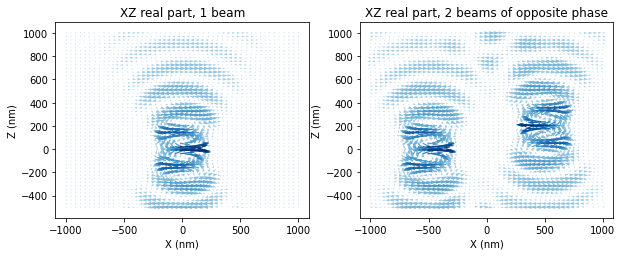

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(121, aspect='equal')
v = visu.vectorfield(NF_1beam, r_probe, complex_part='real', projection=projection, 
                     tit=projection+' real part, 1 beam', show=0)

plt.subplot(122, aspect='equal')
v = visu.vectorfield(NF_2beams, r_probe, complex_part='real', projection=projection, 
                     tit=projection+' real part, 2 beams of opposite phase', show=0)

plt.show()